# Predict taxa from media components

In [1]:
# Add higher directory to python modules path

import sys

sys.path.append("..")

In [2]:
import os

import pandas as pd

from matplotlib import pyplot as plt

import plotly.express as px

from sklearn.cluster import KMeans

import umap

In [3]:
TARGET_VAR = "media_id"

DATA_DIR = "../data/"
CLUSTER_FILE = "ml_input-taxa2component-donato.csv"

RANDOM_SEED = 666

# UMAP parameters
UMAP_METRIC = "euclidean"
UMAP_SEED = 42

## Data preprocessing

**WARNING**: This preprocessing should be done in previous steps!


In [4]:
komodo_df = pd.read_csv(
    os.path.join(
        DATA_DIR,
        "komodo",
        "komodo_taxa.txt"
    ),
    sep="\t"
)

# Transform taxon_id column to string for plotting
komodo_df["taxon_id"] = komodo_df["taxon_id"].astype(str).str.replace(".0", "")

# Add genus column
komodo_df["genus"] = komodo_df["organism_name"].str.split(" ").str[0]

# Get media column as a category
komodo_df["dsmz_id"] = komodo_df["dsmz_id"].astype("category")
komodo_df["media_id"] = komodo_df["dsmz_id"].cat.codes

komodo_df

,dsmz_id,taxon_id,organism_name,media_name,genus,media_id
0,6268,nan,NaN,Substrate for DSM 6268,NaN,8044
1,9849,46125,Abiotrophia defectiva,PYG-MEDIUM (modified),Abiotrophia,8611
2,14247,291968,Acaricomes phytoseiuli,TRYPTICASE SOY Yeast extract medium,Acaricomes,880
3,23669,nan,Acetatifactor muris,For DSM 23669,Acetatifactor,5114
4,5522,2382,Acetitomaculum ruminis,ACETITOMACULUM medium | METHANOBACTERIUM medium,Acetitomaculum,7890
...,...,...,...,...,...,...
8623,473,120045,Zymomonas mobilis subsp. mobilis,ZYMOMONAS medium,Zymomonas,7701
8624,22645,120044,Zymomonas mobilis subsp. pomaceae,ZYMOMONAS medium,Zymomonas,4683
8625,7201,86958,Zymophilus paucivorans,MEDIUM 58 MODIFIED FOR DSM 7201,Zymophilus,8275
8626,20765,86959,Zymophilus raffinosivorans,MEDIUM 58 MODIFIED FOR DSM 20765,Zymophilus,3910


In [5]:
uniprot_df = pd.read_csv(
    os.path.join(
        DATA_DIR,
        "uniprot",
        "komodo_taxon_to_uniprot_ec.csv"
    )
)

uniprot_df["taxonId"] = uniprot_df["taxonId"].astype(str)
uniprot_df = uniprot_df.rename(columns={
    "taxonId": "taxon_id",
    "ecNumbers": "ec_numbers"
})

# Drop all data points that do not contain an EC number
uniprot_df = uniprot_df.dropna(subset="ec_numbers")
uniprot_df

,entryType,primaryAccession,uniProtkbId,taxon_id,fullName,ec_numbers
1,UniProtKB unreviewed (TrEMBL),A0A929MPR1,A0A929MPR1_ABIDE,46125,CTP synthase,6.3.4.2
3,UniProtKB unreviewed (TrEMBL),A0A929QT52,A0A929QT52_ABIDE,46125,Aspartate-semialdehyde dehydrogenase,1.2.1.11
5,UniProtKB unreviewed (TrEMBL),A0A929MMJ5,A0A929MMJ5_ABIDE,46125,Dihydroorotate dehydrogenase,1.3.-.-
6,UniProtKB unreviewed (TrEMBL),A0A929MMW4,A0A929MMW4_ABIDE,46125,Glycerol-3-phosphate dehydrogenase [NAD(P)+],1.1.1.94
7,UniProtKB unreviewed (TrEMBL),A0A929MMY6,A0A929MMY6_ABIDE,46125,Lipid II isoglutaminyl synthase (glutamine-hyd...,6.3.5.13
...,...,...,...,...,...,...
8467,UniProtKB unreviewed (TrEMBL),A0A1H9CYL9,A0A1H9CYL9_9GAMM,355243,Lipoyl synthase,2.8.1.8
8468,UniProtKB unreviewed (TrEMBL),A0A1H9CZ15,A0A1H9CZ15_9GAMM,355243,Serine hydroxymethyltransferase,2.1.2.1
8470,UniProtKB unreviewed (TrEMBL),A0A1H9D344,A0A1H9D344_9GAMM,355243,NAD-dependent protein deacylase,2.3.1.286
8471,UniProtKB unreviewed (TrEMBL),B5A820,B5A820_AMYAL,76020,DNA topoisomerase (ATP-hydrolyzing),5.6.2.2


In [6]:
data_df = pd.merge(
    left=komodo_df,
    right=uniprot_df,
    on="taxon_id",
    how="inner"
)

# Explode EC numbers
data_df["ec_numbers"] = data_df["ec_numbers"].str.split("|")
data_df = data_df.explode("ec_numbers")

data_df = data_df[["taxon_id", "media_id", "ec_numbers"]]\
    .value_counts()\
    .reset_index()

data_df = data_df.pivot(
    index=["taxon_id", "media_id"],
    columns="ec_numbers",
    values="count"
)
data_df = data_df.fillna(0.0).reset_index()
data_df

ec_numbers,taxon_id,media_id,1.-.-.-,1.1.-.-,1.1.1.100,1.1.1.133,1.1.1.135,1.1.1.205,1.1.1.25,1.1.1.262,...,7.2.1.1,7.2.2.14,7.2.2.6,7.2.2.7,7.2.3.1,7.3.2.1,7.3.2.2,7.4.2.5,7.4.2.8,7.6.2.-
0,100469,1377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,102226,7013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1034,8324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1035,8327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,103621,1319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,94136,7818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
383,95160,7096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
384,96473,495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
385,990712,5276,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model

### Strategy for splitting

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_df.drop(["taxon_id", "media_id"], axis=1),
    data_df[TARGET_VAR],
    test_size=0.3,
    random_state=RANDOM_SEED
)

### Dimensionality reduction

In [8]:
reducer = umap.UMAP(
    metric=UMAP_METRIC,
    n_components=4,
    n_epochs=5000,
    random_state=UMAP_SEED,
    n_jobs=1
)

reduced_df = reducer.fit_transform(X_train)
reduced_df = pd.DataFrame(
    reduced_df,
    columns=[f"Component {i+1}" for i in range(reduced_df.shape[1])]
)
reduced_df.head()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,Component 1,Component 2,Component 3,Component 4
0,-222.137161,127.577034,-15.232713,-15.787442
1,-33.486420,7.634564,-55.467014,-20.508331
2,-237.404861,84.254143,-13.122877,10.426279
3,-221.660385,127.362022,-15.379433,-15.743623
4,-221.912582,127.270393,-15.335725,-15.300495


### Clustering

In [9]:
# TODO: add silhouette score
# NOTE: using KMeans since the other classes do not provide a predict method
cluster = KMeans(
    n_clusters=4,
    random_state=RANDOM_SEED
)
reduced_df["Cluster"] = cluster.fit_predict(reduced_df.values)
reduced_df["Cluster"] = reduced_df["Cluster"].astype(str)

In [10]:
# Add ID columns
reduced_df[["taxon_id", "media_id"]] = \
    data_df.loc[X_train.index, ["taxon_id", "media_id"]].values

reduced_df.head()

,Component 1,Component 2,Component 3,Component 4,Cluster,taxon_id,media_id
0,-222.137161,127.577034,-15.232713,-15.787442,0,714,8423
1,-33.486420,7.634564,-55.467014,-20.508331,1,634436,4872
2,-237.404861,84.254143,-13.122877,10.426279,2,95160,7096
3,-221.660385,127.362022,-15.379433,-15.743623,0,281376,1743
4,-221.912582,127.270393,-15.335725,-15.300495,0,52773,3891


#### Visualise the results

In [11]:
fig = px.scatter_3d(
    data_frame=reduced_df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color="Component 4",
    hover_data=[
        "taxon_id",
        "media_id"
    ],
    template="plotly_white"
)
fig.show()

In [12]:
fig = px.scatter_3d(
    data_frame=reduced_df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color="Cluster",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    hover_data=[
        "taxon_id",
        "media_id"
    ],
    template="plotly_white"
)
fig.show()

#### Create new column from clusters

In [13]:
y_train = cluster.predict(reducer.transform(X_train))
y_test = cluster.predict(reducer.transform(X_test))

y_train

array([0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 2, 1, 2, 0, 0, 2, 1,
       1, 3, 2, 0, 2, 3, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       3, 3, 1, 1, 0, 1, 1, 0, 2, 3, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 2, 3,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 3, 2, 3, 2, 2, 1,
       0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 2, 1, 3, 3, 3, 0, 2, 2,
       3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 1, 0, 2, 1, 0, 0, 0, 3, 0, 1,
       0, 0, 0, 1, 2, 3, 1, 0, 0, 1, 0, 2, 1, 2, 1, 0, 2, 0, 1, 0, 0, 2,
       0, 2, 3, 2, 1, 0, 2, 0, 2, 1, 0, 0, 0, 3, 2, 0, 1, 0, 0, 2, 2, 2,
       0, 0, 0, 0, 0, 1, 3, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 2, 3, 1, 0, 2, 2, 3, 2, 1, 0, 0, 0, 0, 2, 0, 2, 3, 1,
       0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 2, 1, 1, 1,
       1, 0, 0, 0, 3, 1, 3, 0, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 2, 0, 0, 1, 0], dtype=int32)

### Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=666)

### Performance

#### Feature importances

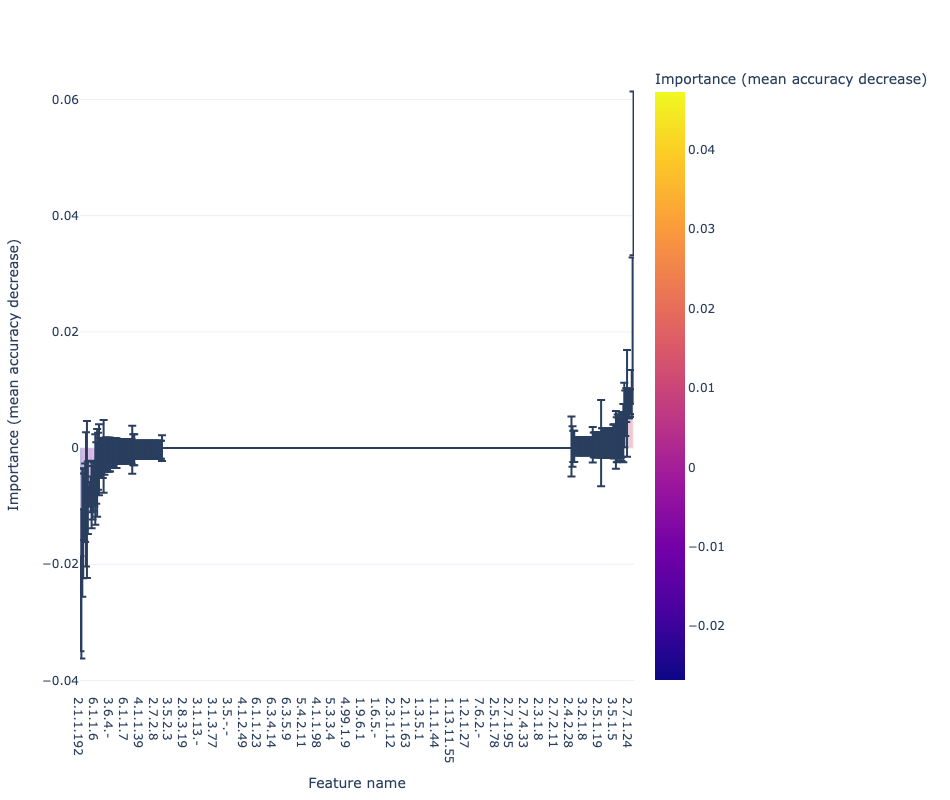

In [15]:
from sklearn.inspection import permutation_importance

result_importances = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=30,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

feat_importances = pd.DataFrame({
    "Feature name": X_train.columns,
    "Importance (mean accuracy decrease)": result_importances.importances_mean,
    "Importance (std)": result_importances.importances_std
})

# Sort them by mean
feat_importances = feat_importances\
    .sort_values("Importance (mean accuracy decrease)")

fig = px.bar(
    data_frame=feat_importances,
    x="Feature name",
    y="Importance (mean accuracy decrease)",
    error_y="Importance (std)",
    color="Importance (mean accuracy decrease)",
    width=950,
    height=800,
    template="plotly_white"
)
fig.show("png")

#### Metrics

In [16]:
y_pred = model.predict(X_test)

report = classification_report(
    y_true=y_test,
    y_pred=y_pred,
    zero_division="warn"
)

print(report)

              precision    recall  f1-score   support

           0       0.98      0.74      0.85        78
           1       0.66      1.00      0.79        27
           2       0.40      0.67      0.50         9
           3       1.00      0.67      0.80         3

    accuracy                           0.79       117
   macro avg       0.76      0.77      0.74       117
weighted avg       0.86      0.79      0.81       117



In [17]:
from sklearn import metrics

# TODO: get PR-REC AUC score
# TODO: plot both ROC and PR-REC curves
roc_score = metrics.roc_auc_score(
    y_true=y_test,
    y_score=model.predict_proba(X_test),
    average="weighted",
    multi_class="ovo"
)

print("ROC AUC score:", roc_score)

ROC AUC score: 0.9633292343406307
